In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
b, A = build_model_data(x, weight)

In [3]:
print('(n, d) = ', A.shape)

(n, d) =  (10000, 2)


## Least squares solution

In [4]:
def full_objective(targets_b, data_A, params_x):
    """Compute the least squares objective over the whole dataset"""
    return 0.5 * np.mean(((data_A @ params_x) - targets_b)**2)

In [5]:
x_star = np.linalg.solve(A.T@A, A.T@b)
best_objective = full_objective(b, A, x_star)
print("f(x*) = ", best_objective)

f(x*) =  15.385887868829398


## Optimization

In [6]:
def minibatch_gradient(targets_b, data_A, params_x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param targets_b: a numpy array of shape (num_examples)
    :param data_A: a numpy array of shape (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    batch_size = len(targets_b)
    err = targets_b - data_A.dot(params_x)
    grad = -data_A.T.dot(err) / batch_size
    return grad

In [7]:
def stochastic_gradient(targets_b, data_A, params_x, batch_size=1):
    """
    Compute a stochastic gradient
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    :param batch_size: integer: number of datapoints to compute the stochastic gradient from
    
    :return: gradient, numpy array of shape (num_features)
    """
    dataset_size = len(targets_b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(targets_b[indices], data_A[indices, :], params_x)

In [8]:
def stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate, 
        decreasing_learning_rate=False):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param initial_learning_rate: float
    :param decreasing_learning_rate: if set to true, the learning rate should decay as 1 / t 
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate

        # update x through the stochastic gradient update
        x = x - lr * grad

        # store x and objective
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)
        
        if iteration % 1000 == 0:
            print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
                  bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

In [ ]:
def stochastic_gradient_descent_with_linesearch(
    targets_b, 
    data_A, 
    initial_x, 
    batch_size, 
    max_iters, 
    initial_learning_rate,
    beta=2.0, 
    gamma=0.1):
    """
    Mini-batch SGD with backtracking line search (Algorithm 1 from Vaswani et al.)
    
    :param gamma: Armijo condition parameter (typically small like 0.1)
    :param beta: Factor to decrease learning rate if Armijo condition is not satisfied
    """
    xs = [initial_x]
    objectives = []
    x = initial_x.copy()

    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        grad_norm_sq = np.linalg.norm(grad) ** 2
        lr = initial_learning_rate
        
        # Backtracking line search
        while True:
            x_new = x - lr * grad
            f_x_new = full_objective(targets_b, data_A, x_new)
            f_x = full_objective(targets_b, data_A, x)
            
            if f_x_new <= f_x - gamma * lr * grad_norm_sq:
                break
            lr /= beta

        # Apply update
        x = x - lr * grad
        
        # Logging
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)

        if iteration % 1000 == 0:
            print("SGD-LS({bi:04d}/{ti:04d}): lr={lr:.4e}, obj={l:.4f}".format(
                bi=iteration, ti=max_iters - 1, lr=lr, l=objective))

    return objectives, xs


In [16]:
# Define the parameters of the algorithm.
max_iters = int(1e4)  # 10 passes through the dataset
gamma = 0.01   # this is totally arbitrary
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/9999): objective =    2767.74
SGD(1000/9999): objective =      15.42
SGD(2000/9999): objective =      15.93
SGD(3000/9999): objective =      15.45
SGD(4000/9999): objective =      15.60
SGD(5000/9999): objective =      15.63
SGD(6000/9999): objective =      15.39
SGD(7000/9999): objective =      15.52
SGD(8000/9999): objective =      15.49
SGD(9000/9999): objective =      15.69
SGD: execution time=5.529 seconds


In [31]:
# Define the parameters of the algorithm.
max_iters = int(1e3)  # 10 passes through the dataset
gamma = 0.05   # this is totally arbitrary
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd__line_objectives, sgd_line_xs = stochastic_gradient_descent_with_linesearch(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD-LS(0000/0999): lr=5.0000e-02, obj=2518.5574
SGD: execution time=5.832 seconds


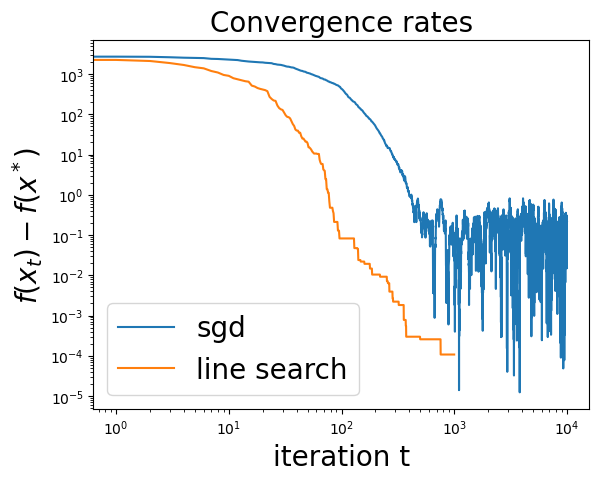

In [32]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = 'sgd')
plt.loglog(sgd__line_objectives - best_objective, label = 'line search')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()